In [1]:
import sys
sys.path.insert(0, "../../")

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'FAB',
 'FAB.png',
 'MoG.png',
 'MoG_FAB.png',
 'MoG_init.png',
 'MoG_NF.png',
 'MoG_SNF.png',
 'NF',
 'NF.png',
 'Plots.ipynb',
 'SFNsipynb.ipynb',
 'SNF']

In [3]:
import torch
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from datetime import datetime
from FittedModels.utils.model_utils import sample_and_log_w_big_batch_drop_nans

In [4]:
import pathlib
def load_model(tester, checkpoints_path, epoch, load_AIS=True):
    path = pathlib.Path(checkpoints_path)
    tester.learnt_sampling_dist.load_model(path, epoch)
    if load_AIS:
        tester.AIS_train.transition_operator_class.load_model(path, epoch)

# Plotter

In [40]:
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
rc('axes', titlesize=10, labelsize = 8)     # fontsize of the axes title and labels
rc('legend',fontsize=6)
rc('xtick', labelsize=5.5) 
rc('ytick', labelsize=5.5)
import itertools
def plot_marginals(axs, learnt_dist_manager, n_samples=1000, title=None, samples_q=None,
                   clamp_samples=10, alpha=0.2, dim=None, clip_min = -1000, ylabel=True, xlabel=True):
    if dim is None:
        dim = learnt_dist_manager.target_dist.dim
    if samples_q is None:
        samples_q = learnt_dist_manager.learnt_sampling_dist.sample((n_samples,))
    if isinstance(clamp_samples, int):
        samples_q = torch.clamp(samples_q, -clamp_samples, clamp_samples).cpu().detach().numpy()
    else:
        for i, clamp_dim in enumerate(clamp_samples):  # list of min max per dimension
            samples_q[:, i] = torch.clamp(samples_q[:, i], clamp_dim[0], clamp_dim[1])
        samples_q = samples_q.cpu().detach().numpy()
    if dim == 2:
        if learnt_dist_manager is not None:
            n_points_contour = 200
            if isinstance(clamp_samples, int):
                x_points_dim1 = torch.linspace(-clamp_samples, clamp_samples, n_points_contour)
                x_points_dim2 = torch.linspace(-clamp_samples, clamp_samples, n_points_contour)
            else:
                x_points_dim1 = torch.linspace(clamp_samples[0][0], clamp_samples[0][1], n_points_contour)
                x_points_dim2 = torch.linspace(clamp_samples[1][0], clamp_samples[1][1], n_points_contour)
            x_points = torch.tensor(list(itertools.product(x_points_dim1, x_points_dim2)))
            p_x = learnt_dist_manager.target_dist.log_prob(x_points.to(learnt_dist_manager.device))
            p_x = torch.clamp_min(p_x, clip_min)
            p_x = p_x.cpu().detach().numpy()
            p_x = p_x.reshape((n_points_contour, n_points_contour))
            x_points_dim1 = x_points[:, 0].reshape((n_points_contour, n_points_contour)).numpy()
            x_points_dim2 = x_points[:, 1].reshape((n_points_contour, n_points_contour)).numpy()
            axs.contour(x_points_dim1, x_points_dim2, p_x, levels=80)
            if xlabel:
                axs.set_xlabel(r"$x_1$")
            if ylabel:
                axs.set_ylabel(r"$x_2$")
        axs.plot(samples_q[:, 0], samples_q[:, 1], "o", alpha=alpha)
        if title != None:
            axs.set_title(title)
    else:
        raise Exception
        
clamp_at = [[-25, 20], [-20, 10]]

def plotter(axs, *args, **kwargs):
    plot_marginals(axs, *args, **kwargs, clamp_samples=clamp_at)

# Target Problem

In [6]:
dim = 2
non_default_flow_width = None
seed = 2
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)

In [7]:
assert seed == 2
assert dim == 2
from TargetDistributions.MoG import MoG
from FittedModels.utils.plotting_utils import plot_marginals
target = MoG(dim=dim, n_mixes=5, min_cov=1, loc_scaling=10)
if non_default_flow_width is None:
    scaling_factor_flow = 1.0
else:
    scaling_factor_flow = non_default_flow_width
clamp_at = [[-25, 20], [-20, 10]]

true expectation is 205.50649304648894


# FAB

In [8]:
problem = "MoG_2D_illustration"
dim = 2
seed = 2
problem_kwargs = {}
save = True
epochs = int(1e3)
batch_size = int(100)
n_samples_expectation = batch_size*10
KPI_batch_size = batch_size*10
n_flow_steps = 10
n_plots = 5
n_distributions = 2 + 2
experiment_name = "workshop_MoG"
flow_type = "RealNVP" 
HMC_tune_options = [ "No-U", "p_accept", "No-U-unscaled" ]
HMC_transition_args = {"step_tuning_method": HMC_tune_options[1]}
train_AIS_kwargs = {"lr": 5e-4, "optimizer": "AdamW"}
learnt_sampler_kwargs = {"nodes_per_x": 20}

In [14]:
learnt_sampler_FAB_init = FlowModel(x_dim=dim, scaling_factor=scaling_factor_flow, flow_type=flow_type,
                               n_flow_steps=n_flow_steps, **learnt_sampler_kwargs)
FAB_init = AIS_trainer(target, learnt_sampler_FAB_init, n_distributions=n_distributions
                     , tranistion_operator_kwargs=HMC_transition_args, transition_operator="HMC",
                     **train_AIS_kwargs)

setting device as cpu


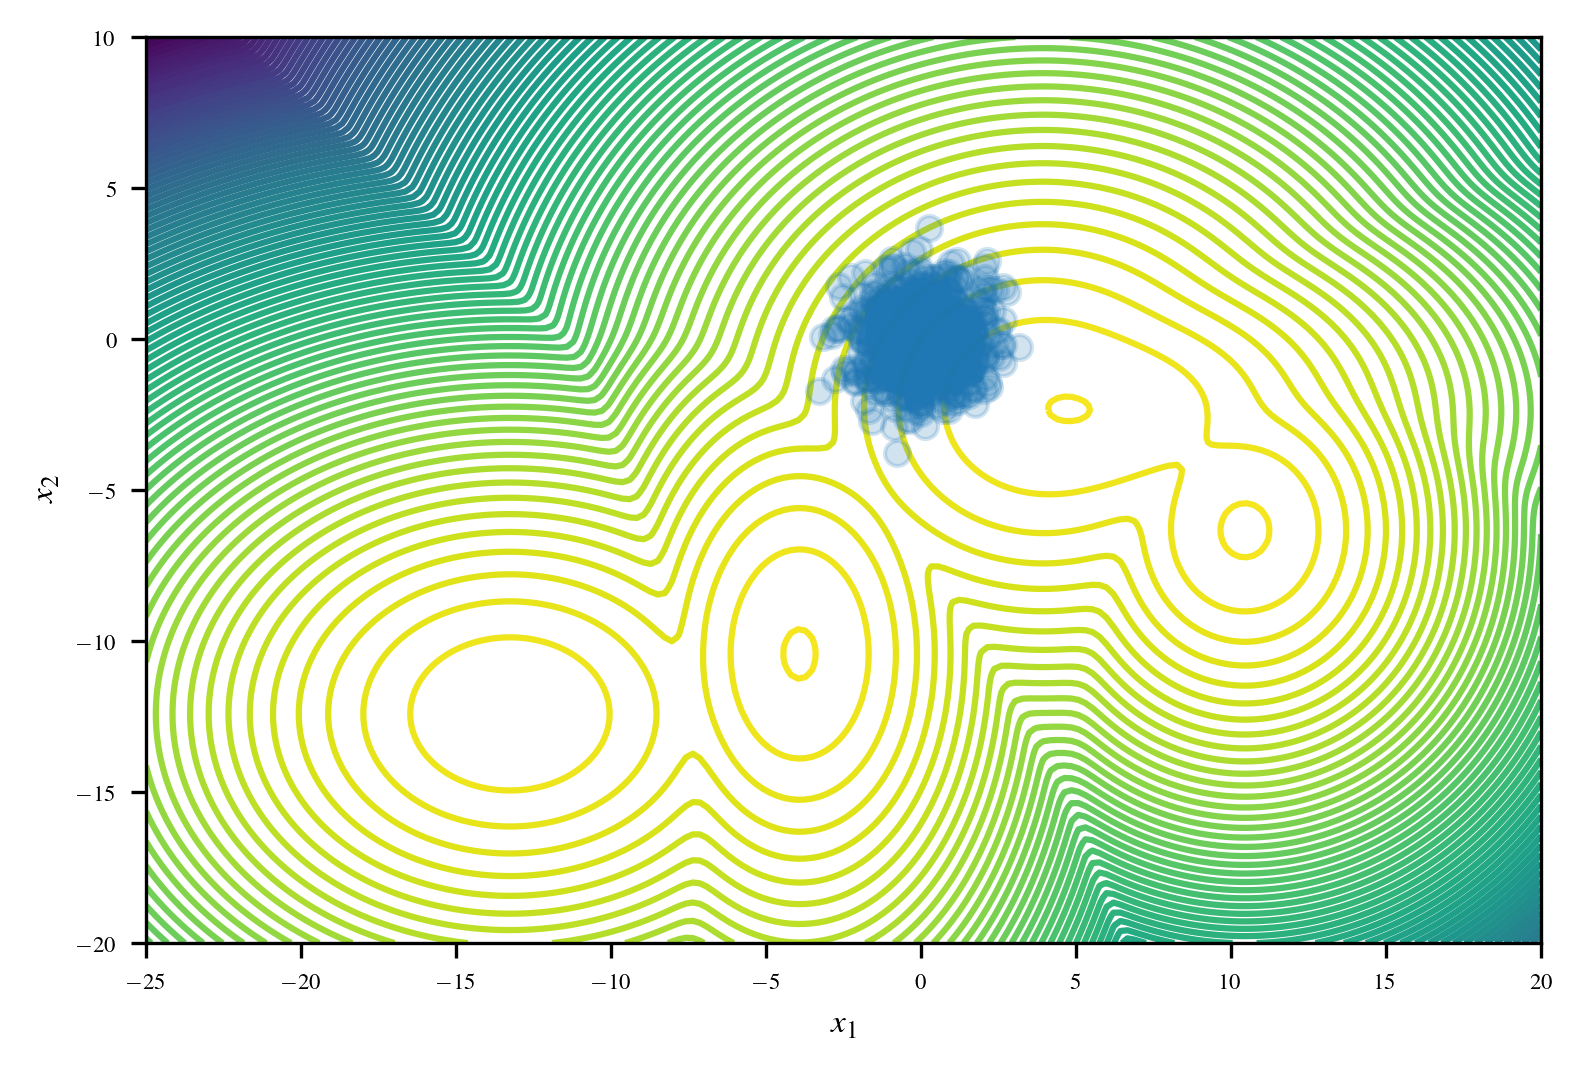

In [15]:
fig, axs = plt.subplots()
plotter(axs, FAB_init)
#plt.savefig("MoG_init.png", bbox_inches='tight')

In [16]:
learnt_sampler_FAB = FlowModel(x_dim=dim, scaling_factor=scaling_factor_flow, flow_type=flow_type,
                               n_flow_steps=n_flow_steps, **learnt_sampler_kwargs)
FAB = AIS_trainer(target, learnt_sampler_FAB, n_distributions=n_distributions
                     , tranistion_operator_kwargs=HMC_transition_args, transition_operator="HMC",
                     **train_AIS_kwargs)

setting device as cpu


In [17]:
os.listdir()

['.ipynb_checkpoints',
 'FAB',
 'FAB.png',
 'MoG.png',
 'MoG_FAB.png',
 'MoG_init.png',
 'MoG_NF.png',
 'MoG_SNF.png',
 'NF',
 'NF.png',
 'Plots.ipynb',
 'SFNsipynb.ipynb',
 'SNF']

In [18]:
load_model(FAB,"FAB", epoch=None, load_AIS=True)

loaded flow model
loaded HMC model


In [19]:
torch.manual_seed(seed)
test_samples = target.sample((10000,))
log_probs_test = FAB.learnt_sampling_dist.log_prob(test_samples)
mean_log_q_x_test_samples = torch.mean(log_probs_test).item()
mean_log_q_x_test_samples

-5.174937878906586

In [20]:
x_samples, log_w = sample_and_log_w_big_batch_drop_nans(FAB, 100*1000,
                                                        1000, AIS=False)
target.performance_metrics(FAB, x_samples, log_w, n_batches_stat_aggregation=100)

({'bias_normed': 0.0004403034299708693, 'std_normed': 0.05756981664854859}, {})

In [21]:
x_samples, log_w = sample_and_log_w_big_batch_drop_nans(FAB.AIS_train, 100*1000,
                                                        1000, AIS=True)
print(target.performance_metrics(FAB, x_samples, log_w, n_batches_stat_aggregation=100))

({'bias_normed': 0.005097903464136891, 'std_normed': 0.05484367508616508}, {})


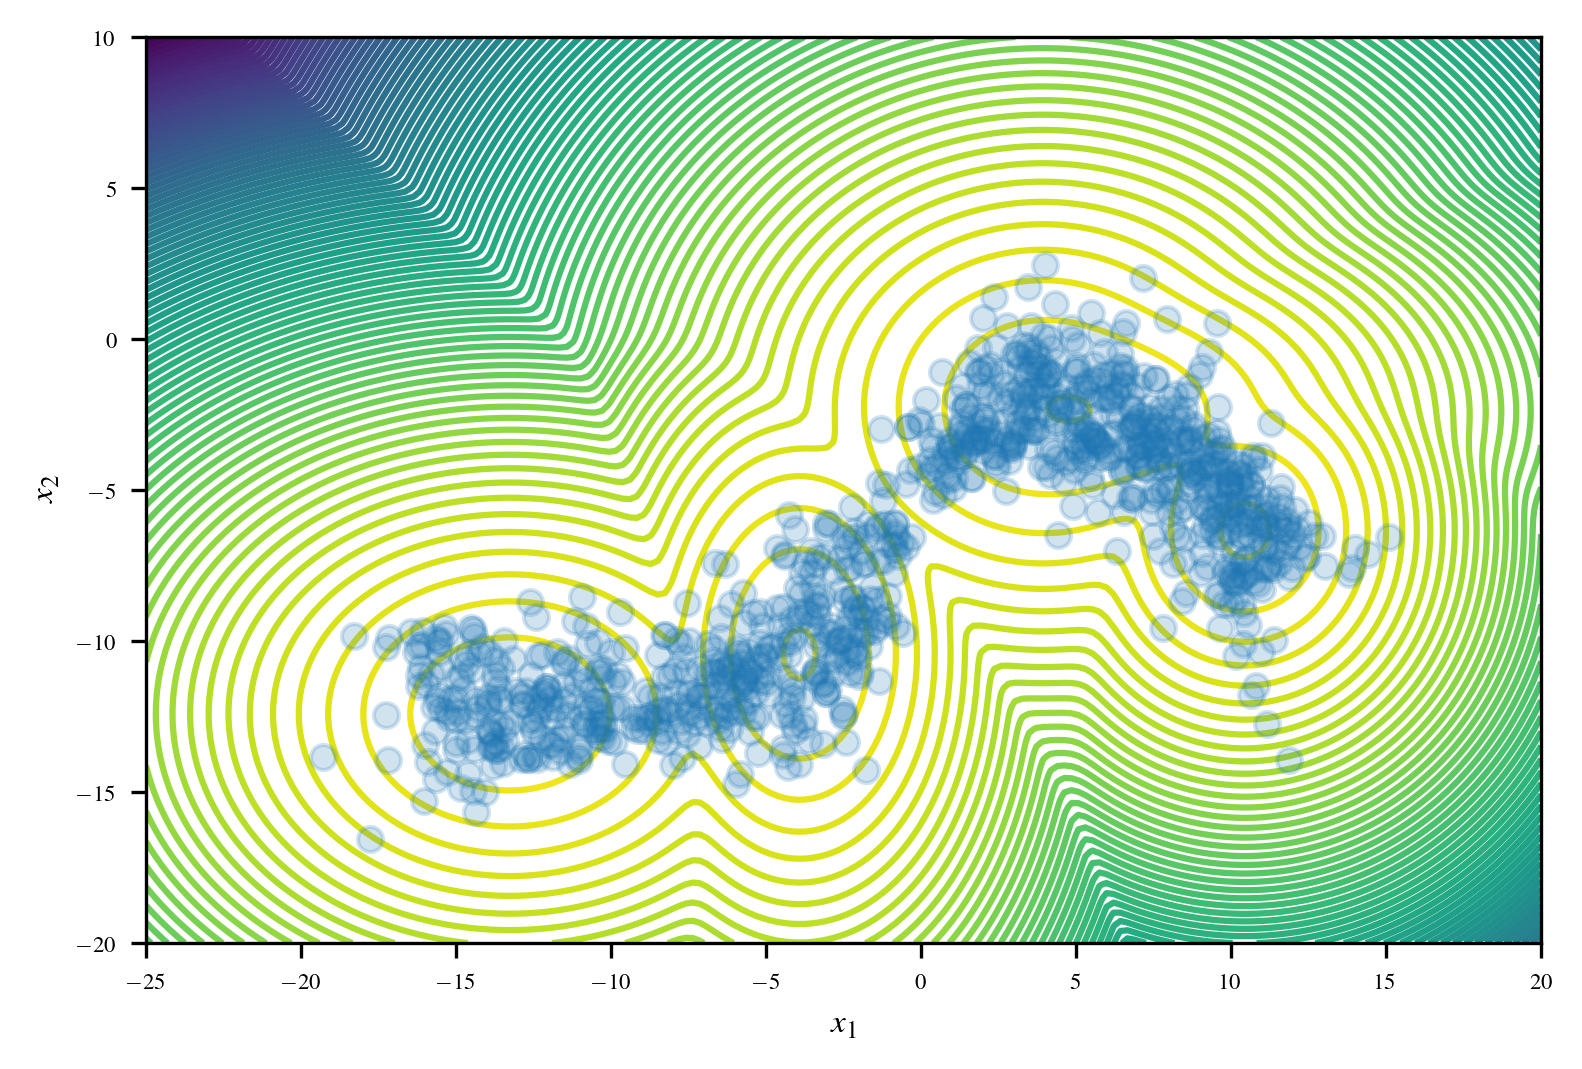

In [22]:
fig, axs = plt.subplots()
plotter(axs, FAB)
#plt.savefig("MoG_FAB.png", bbox_inches='tight')

# NF

In [23]:
# run a model and save checkpoints
problem = "MoG_2D_illustration"
dim = 2
seed = 2
problem_kwargs = {}
save = True
epochs = int(1e3)
batch_size = int(100)
n_samples_expectation = batch_size*10
KPI_batch_size = batch_size*10
n_flow_steps = 10
n_plots = 5
n_distributions = 2 + 0
experiment_name = "workshop_MoG"
flow_type = "RealNVP" 
HMC_tune_options = [ "No-U", "p_accept", "No-U-unscaled" ]
HMC_transition_args = {"step_tuning_method": HMC_tune_options[1]}
train_AIS_kwargs = {"lr": 5e-4, "optimizer": "AdamW", "loss_type":  "kl_q"}
learnt_sampler_kwargs = {"nodes_per_x": 20}

In [24]:
learnt_sampler_FAB = FlowModel(x_dim=dim, scaling_factor=scaling_factor_flow, flow_type=flow_type,
                               n_flow_steps=n_flow_steps, **learnt_sampler_kwargs)
NF = AIS_trainer(target, learnt_sampler_FAB, n_distributions=n_distributions
                     , tranistion_operator_kwargs=HMC_transition_args, transition_operator="HMC",
                     **train_AIS_kwargs)

running without any intermediate distributions
setting device as cpu


In [25]:
load_model(NF, "NF", epoch=None, load_AIS=False)

loaded flow model


In [26]:
torch.manual_seed(seed)
test_samples = target.sample((10000,))
log_probs_test = NF.learnt_sampling_dist.log_prob(test_samples)
mean_log_q_x_test_samples = torch.mean(log_probs_test).item()
mean_log_q_x_test_samples

-14.439504877362822

In [27]:
x_samples, log_w = sample_and_log_w_big_batch_drop_nans(NF, 100*1000,
                                                        1000, AIS=False)
target.performance_metrics(NF, x_samples, log_w, n_batches_stat_aggregation=100)

({'bias_normed': 1.0084323943329692, 'std_normed': 0.16356605216944903}, {})

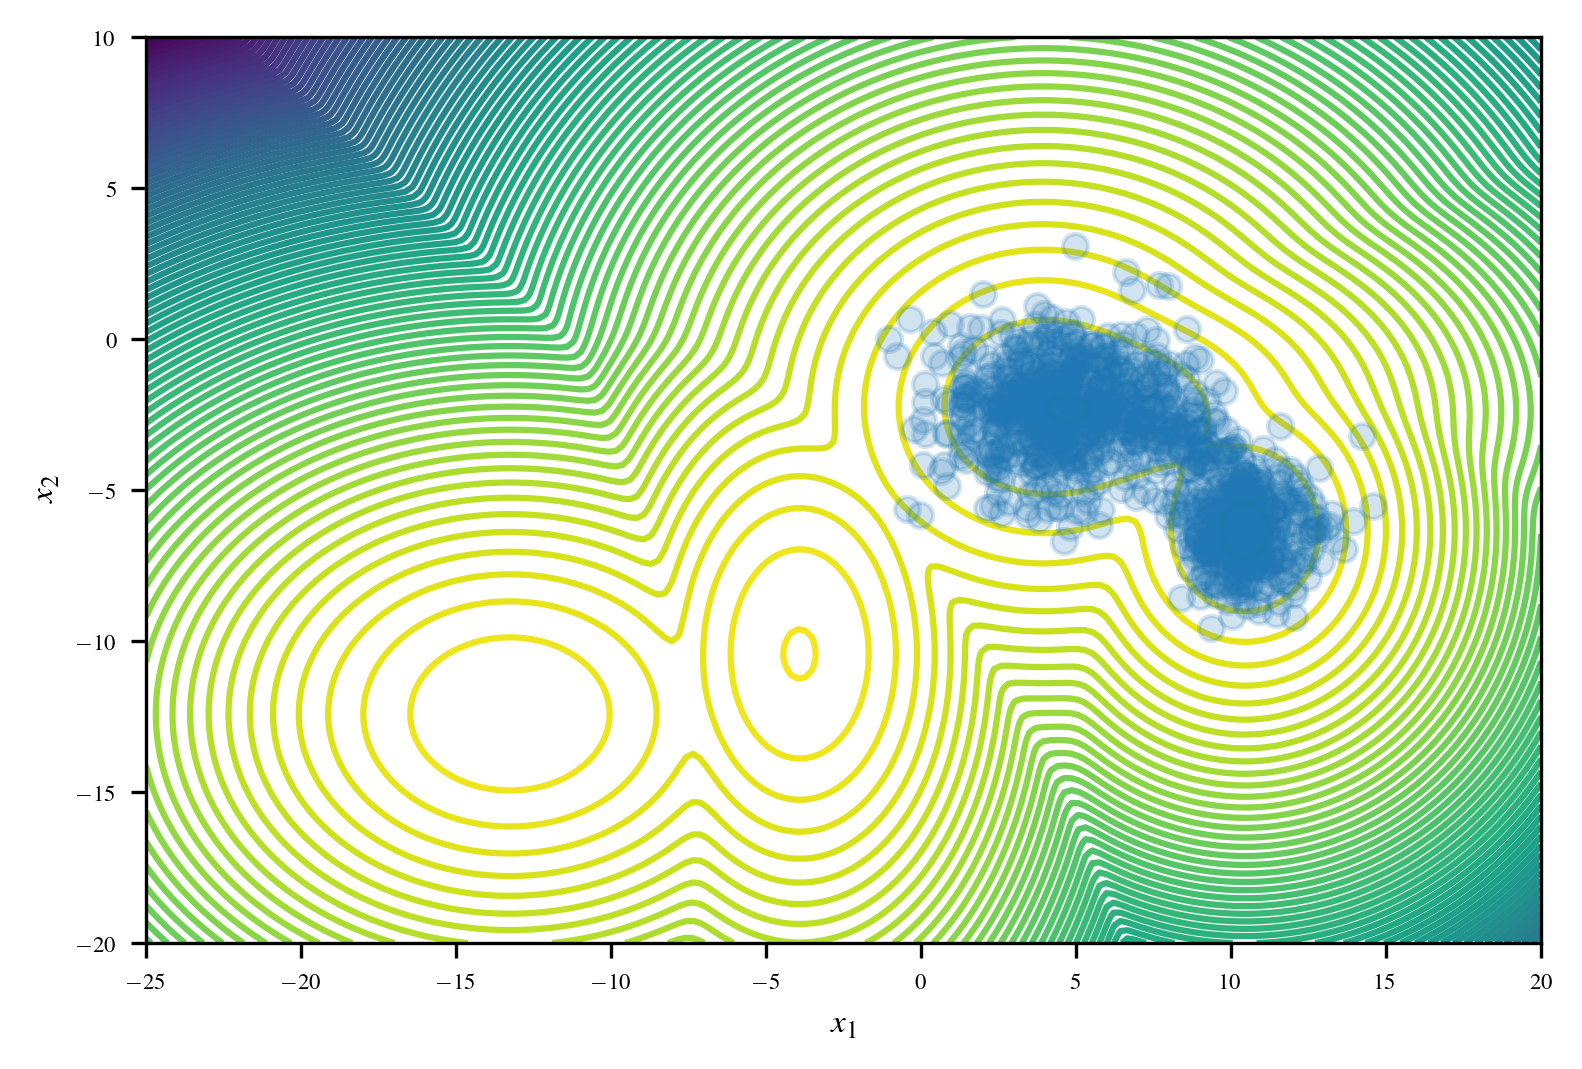

In [28]:
fig, axs = plt.subplots()
plotter(axs, NF)
#plt.savefig("MoG_NF.png", bbox_inches='tight')

# SNF

In [29]:
os.listdir()

['.ipynb_checkpoints',
 'FAB',
 'FAB.png',
 'MoG.png',
 'MoG_FAB.png',
 'MoG_init.png',
 'MoG_NF.png',
 'MoG_SNF.png',
 'NF',
 'NF.png',
 'Plots.ipynb',
 'SFNsipynb.ipynb',
 'SNF']

In [30]:
import numpy as np

In [31]:
os.listdir("SNF")

['SNF.npy']

In [32]:
SNF_samples = torch.tensor(np.load("SNF/SNF.npy"))

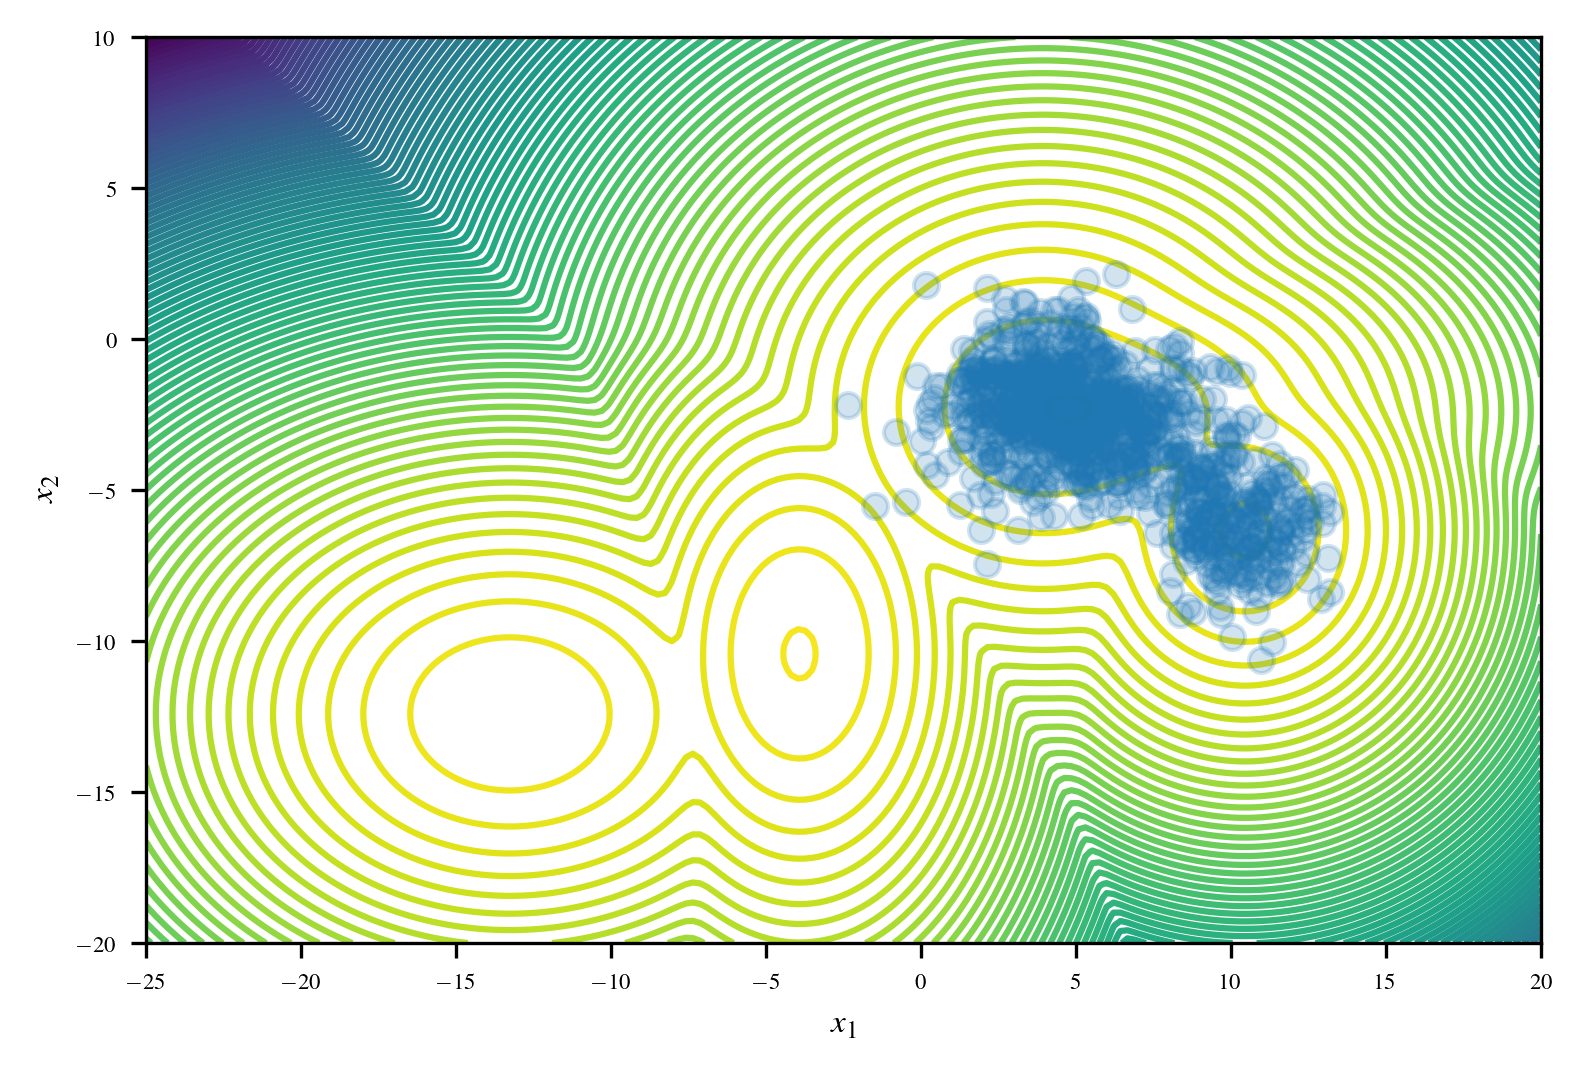

In [33]:
fig, axs = plt.subplots()
plotter(axs, NF, samples_q = SNF_samples)
#plt.savefig("MoG_SNF.png", bbox_inches='tight')

# Plot all together

In [36]:
rc("lines", linewidth=1.0)
rc("lines", markersize=2.0)
rc('axes', titlesize=10, labelsize = 8)   
rc('legend',fontsize=8)
rc('xtick', labelsize=7) 
rc('ytick', labelsize=7)

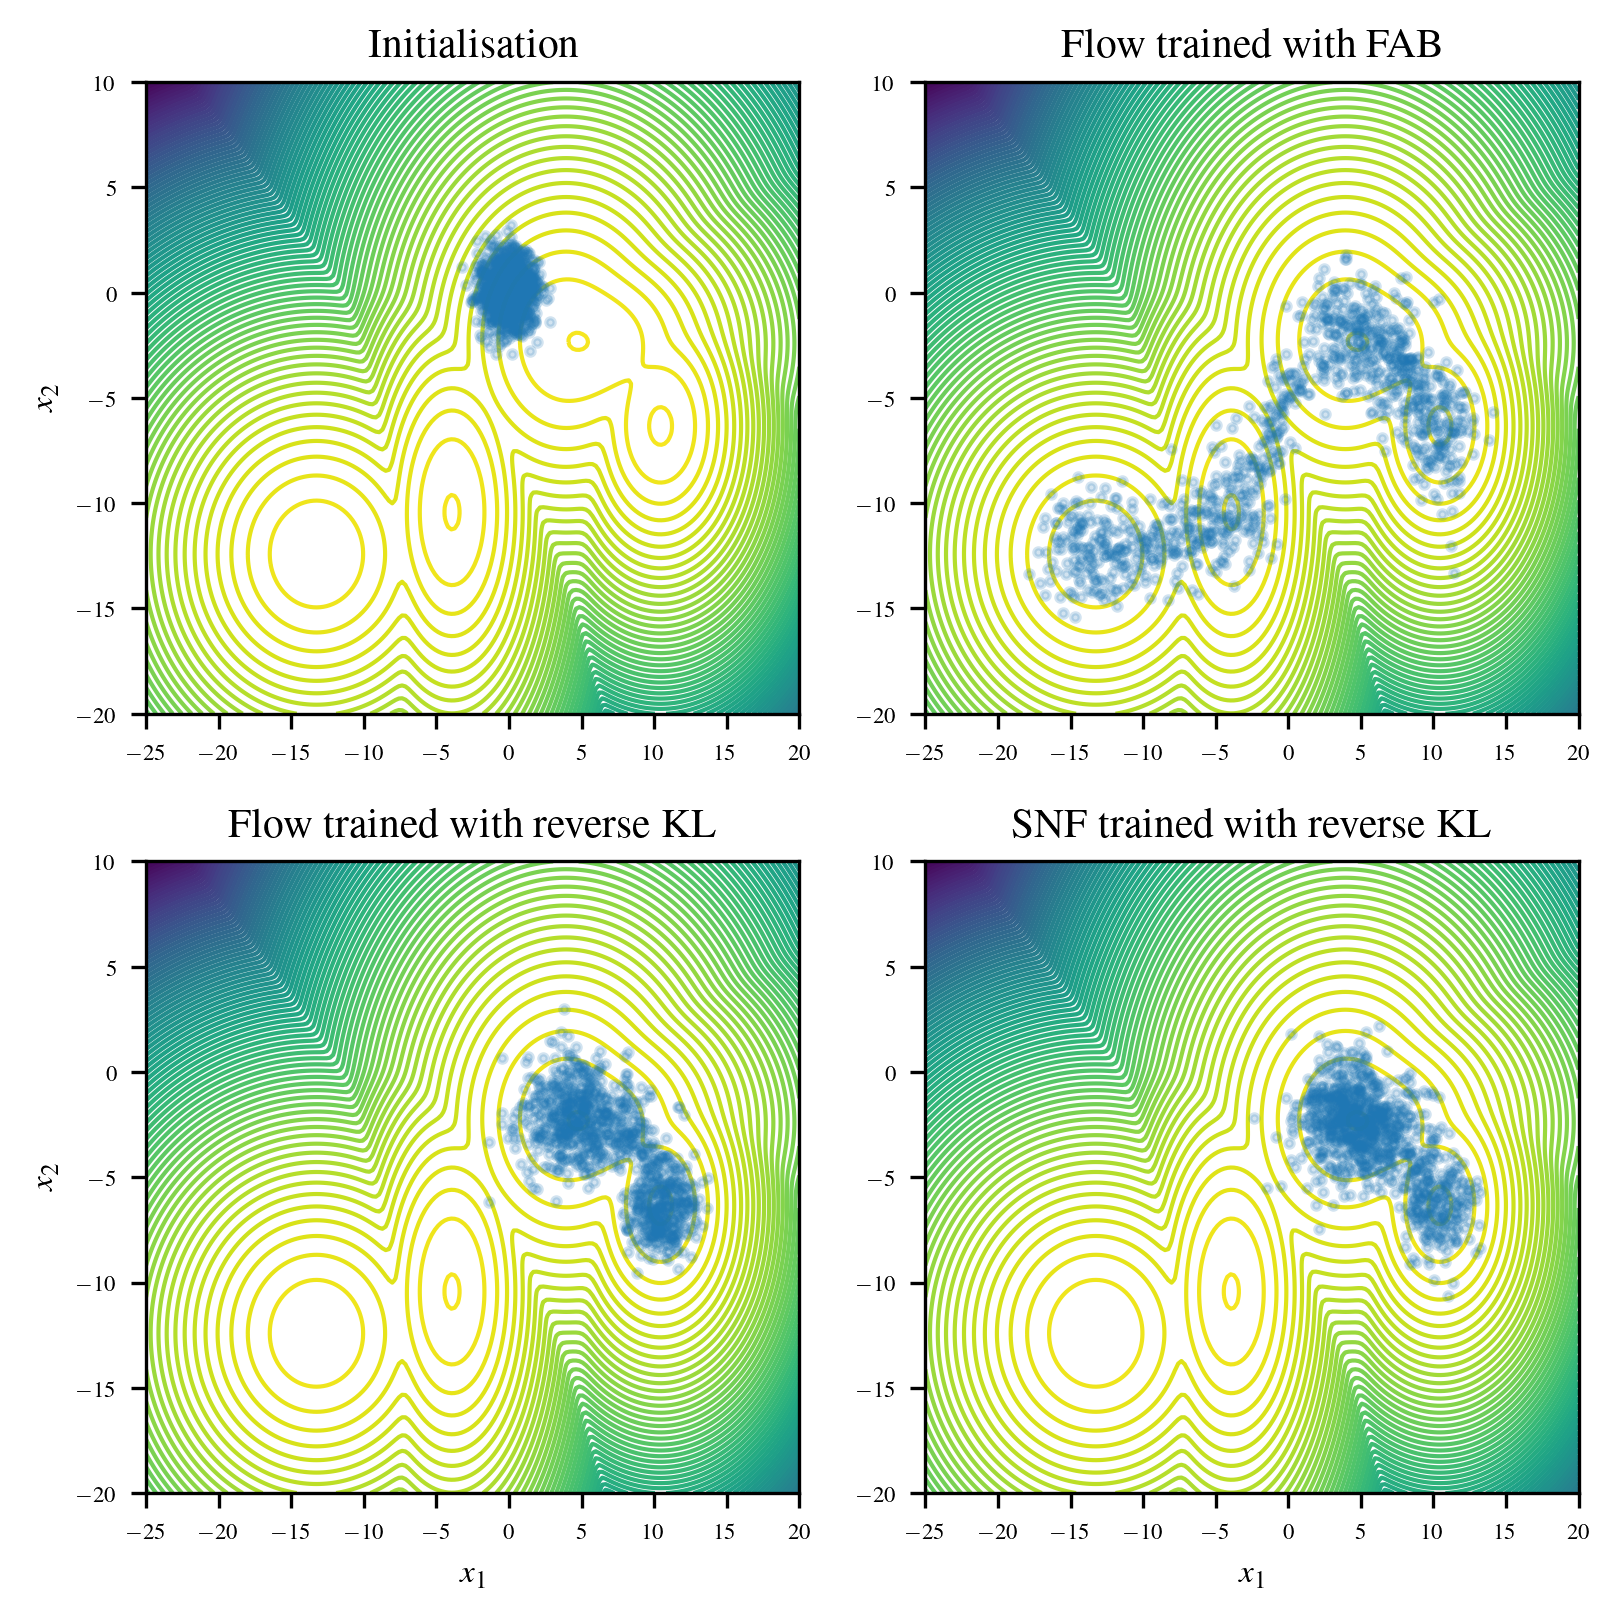

In [42]:
width = 5.5
height = 5.5
fig, axs = plt.subplots(2,2, figsize=(width, height))
plotter(axs[0, 0], FAB_init, xlabel=False)
axs[0, 0].set_title("Initialisation")
plotter(axs[0, 1], FAB, ylabel=False, xlabel=False)
axs[0, 1].set_title("Flow trained with FAB")
plotter(axs[1, 0], NF)
axs[1, 0].set_title("Flow trained with reverse KL")
plotter(axs[1,1], NF, samples_q = SNF_samples, ylabel=False)
axs[1, 1].set_title("SNF trained with reverse KL")
plt.tight_layout()
plt.savefig("MoG.png", bbox_inches='tight')

In [ ]:
def plot_marginals(axs, learnt_dist_manager, n_samples=1000, title=None, samples_q=None,
                   clamp_samples=10, alpha=0.2, dim=None):
    if dim is None:
        dim = learnt_dist_manager.target_dist.dim
    if samples_q is None:
        samples_q = learnt_dist_manager.learnt_sampling_dist.sample((n_samples,))
    if isinstance(clamp_samples, int):
        samples_q = torch.clamp(samples_q, -clamp_samples, clamp_samples).cpu().detach().numpy()
    else:
        for i, clamp_dim in enumerate(clamp_samples):  # list of min max per dimension
            samples_q[:, i] = torch.clamp(samples_q[:, i], clamp_dim[0], clamp_dim[1])
        samples_q = samples_q.cpu().detach().numpy()
    if dim == 2:
        if learnt_dist_manager is not None:
            n_points_contour = 200
            if isinstance(clamp_samples, int):
                x_points_dim1 = torch.linspace(-clamp_samples, clamp_samples, n_points_contour)
                x_points_dim2 = torch.linspace(-clamp_samples, clamp_samples, n_points_contour)
            else:
                x_points_dim1 = torch.linspace(clamp_samples[0][0], clamp_samples[0][1], n_points_contour)
                x_points_dim2 = torch.linspace(clamp_samples[1][0], clamp_samples[1][1], n_points_contour)
            x_points = torch.tensor(list(itertools.product(x_points_dim1, x_points_dim2)))
            p_x = learnt_dist_manager.target_dist.log_prob(x_points.to(learnt_dist_manager.device))
            p_x = torch.clamp_min(p_x, -1000)
            p_x = p_x.cpu().detach().numpy()
            p_x = p_x.reshape((n_points_contour, n_points_contour))
            x_points_dim1 = x_points[:, 0].reshape((n_points_contour, n_points_contour)).numpy()
            x_points_dim2 = x_points[:, 1].reshape((n_points_contour, n_points_contour)).numpy()
            axs.contour(x_points_dim1, x_points_dim2, p_x, levels=80)
            axs.set_xlabel(r"$x_1$")
            axs.set_ylabel(r"$x_2$")
        axs.plot(samples_q[:, 0], samples_q[:, 1], "o", alpha=alpha)
        if title != None:
            axs.set_title(title)
    else:
        raise Exception
        
clamp_at = [[-25, 20], [-20, 10]]